# Question 4: 混合整数計画法 (1)

=============================================================================================

さて、まずは混合整数計画法について説明したいと思います。  
そもそも、最適化問題とは、与えられた制約条件の中で目的関数を最小にする問題のことを指します。制約・目的関数は線形か、非線形か、変数は連続か、非連続かなどで、様々な種別の最適化問題がありますが、今回扱う混合整数計画問題は下記のような特徴を持っています。  

・目的関数が線形関数  
・全ての制約条件が線形の等式もしくは不等式  
・一部の変数が離散的である  

もし全ての変数が連続であるならば、線形計画問題と呼ぶことが多いです。  
混合整数計画問題は、一部の変数が離散的な線形計画問題のことである、と表現されることもあります。  

## ナップサック問題
https://axross-recipe.com/recipes/102

問題）様々な冒険を経て宝島に辿り着いたあなたは、そこにある全ての宝をリュックに入れて持ち帰ろうとする...そんな突飛なケースを考えてみましょう。残念ながら、リュックには65kgまでしか宝を詰めることが出来ないため、うまくお宝を選びながら利益が最大になるような組み合わせを考える必要があります。

宝島のお宝  
宝0 : value0 = 105万円 / weight0 = 10kg  
宝1 : value1 = 140万円 / weight1 = 13kg  
宝2 : value2 = 70万円 / weight2 = 6kg  
宝3 : value3 = 90万円 / weight3 = 11kg  
宝4 : value4 = 220万円 / weight4 = 20kg  
宝5 : value5 = 170万円 / weight5 = 18kg  

数理最適化のライブラリー pulp とCVXPY を用いて解きなさい。

=============================================================================================


この問題を最適化問題に定式化する訳ですが、そのためには、「宝Xを何個詰めるか？」という変数「amount」を導入します。これは決定変数と呼ばれ、最適化を通して、最適なamount_i (i=0~5)を算出するということになります。目的関数と制約関数は以下のように設定すれば良いです。じっくり見て、意味を理解してみてください。

【目的関数】
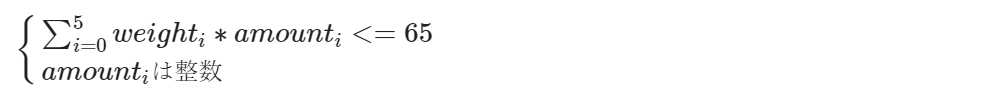

【制約条件】
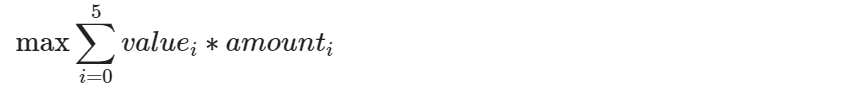

## Pulpによる解法

In [1]:
!pip install pulp

     |████████████████████████████████| 14.2 MB 4.9 MB/s 


In [2]:
from pulp import * 

In [3]:
# データ
values = [105,140,65,90,220,170]
weights = [10,13,6,11,20,18]

# 問題の定義
problem = LpProblem('knapsack', LpMaximize)

# 目的関数の定義
amounts = [LpVariable('amount_{0}'.format(i), lowBound = 0, cat = "Integer") for i in range(len(weights))]
problem += lpDot(values, amounts)

# 制約条件
problem += lpDot(weights, amounts) <= 65

print(problem)

knapsack:
MAXIMIZE
105*amount_0 + 140*amount_1 + 65*amount_2 + 90*amount_3 + 220*amount_4 + 170*amount_5 + 0
SUBJECT TO
_C1: 10 amount_0 + 13 amount_1 + 6 amount_2 + 11 amount_3 + 20 amount_4
 + 18 amount_5 <= 65

VARIABLES
0 <= amount_0 Integer
0 <= amount_1 Integer
0 <= amount_2 Integer
0 <= amount_3 Integer
0 <= amount_4 Integer
0 <= amount_5 Integer



In [4]:
%%time
# 解く
status = problem.solve()
print(LpStatus[status])

Optimal
CPU times: user 1.57 ms, sys: 6.97 ms, total: 8.53 ms
Wall time: 36.8 ms


In [5]:
# 結果表示
ttl_weight = 0
ttl_value = 0
for i in range(6):
    print("お宝{0}は{1}個詰める".format(i, amounts[i].value()))
    ttl_weight += amounts[i].value() * weights[i]
    ttl_value += amounts[i].value() * values[i]
print("総重量：{0}kg , 総価値：{1}万円".format(ttl_weight, ttl_value))

お宝0は0.0個詰める
お宝1は1.0個詰める
お宝2は2.0個詰める
お宝3は0.0個詰める
お宝4は2.0個詰める
お宝5は0.0個詰める
総重量：65.0kg , 総価値：710.0万円


## CVXPYによる解法
https://towardsdatascience.com/integer-programming-in-python-1cbdfa240df2  
https://myenigma.hatenablog.com/entry/2017/04/10/074451  
https://www.titanwolf.org/Network/q/b79727df-212d-4a16-bfb2-c67b6b97abe2/y

In [6]:
import cvxpy as cp

In [7]:
# データ
values = [105,140,65,90,220,170]
weights = [10,13,6,11,20,18]
capacity = 65

# 変数の定義
# x = cp.Bool(len(weights)) # 古いコード
amounts = cp.Variable(len(weights), boolean=True) # 新しいコード

# 制約条件の定義
constraints = [capacity >= weights @ amounts] # @ 内積をする、np.dot()と同じ

# 問題の定義
objective = cp.Maximize(values @ amounts)

# 目的関数の定義
prob = cp.Problem(objective, constraints)
print(prob)

maximize [105. 140.  65.  90. 220. 170.] * var0
subject to [10. 13.  6. 11. 20. 18.] * var0 <= 65.0


In [8]:
amounts

Variable((6,), boolean=True)

In [9]:
%%time
# 解く
prob.solve()  # Returns the optimal value.
print("status:", prob.status)

status: optimal
CPU times: user 11.7 ms, sys: 2.45 ms, total: 14.2 ms
Wall time: 35.3 ms


In [10]:
print(amounts.value)

[1. 0. 1. 1. 1. 1.]


In [11]:
# 結果表示
ttl_weight = 0
ttl_value = 0
for i in range(6):
    print("お宝{0}は{1}個詰める".format(i, amounts.value[i]))
    ttl_weight += amounts.value[i] * weights[i]
    ttl_value += amounts.value[i] * values[i]
print("総重量：{0}kg , 総価値：{1}万円".format(ttl_weight, ttl_value))

お宝0は1.0個詰める
お宝1は0.0個詰める
お宝2は1.0個詰める
お宝3は1.0個詰める
お宝4は1.0個詰める
お宝5は1.0個詰める
総重量：65.0kg , 総価値：650.0万円


なんとpulpで解いた解答と違う。  

<pulp解答>  
お宝0は0.0個詰める  
お宝1は1.0個詰める  
お宝2は2.0個詰める  
お宝3は0.0個詰める  
お宝4は2.0個詰める  
お宝5は0.0個詰める  
総重量：65.0kg , 総価値：710.0万円  

そうか、pulp の amounts = [LpVariable('amount_{0}'.format(i), lowBound = 0, cat = "Integer") for i in range(6)] のコードでは、  
お宝の数は正の整数だと定義したのに、今回の cvxpy のコードでは、0個か1個の Boolean にしたからだ。  
では、泥臭いコードになると思うけど CVXPY のコードを改良しよう。

## 改良版 CVXPY コード

In [12]:
# データ
values = [105,140,65,90,220,170]
weights = [10,13,6,11,20,18]
capacity = 65

amounts = cp.Variable(len(weights), integer=True)

# 制約条件の定義
constraints = [capacity >= weights @ amounts, # @　内積を表す np.dot() と同様の処理
               # amounts[i] >=0 if i in range(len(weights))] # ループで上手く書けなかった
               amounts[0] >=0,
               amounts[1] >=0,
               amounts[2] >=0,
               amounts[3] >=0,
               amounts[4] >=0,
               amounts[5] >=0]

# 問題の定義
objective = cp.Maximize(values @ amounts)

# 目的関数の定義
prob = cp.Problem(objective, constraints)
print(prob)

maximize [105. 140.  65.  90. 220. 170.] * var26
subject to [10. 13.  6. 11. 20. 18.] * var26 <= 65.0
           0.0 <= var26[0]
           0.0 <= var26[1]
           0.0 <= var26[2]
           0.0 <= var26[3]
           0.0 <= var26[4]
           0.0 <= var26[5]


In [13]:
amounts

Variable((6,), integer=True)

In [14]:
%%time
# 解く
prob.solve()  # Returns the optimal value.
print("status:", prob.status)

status: optimal
CPU times: user 22 ms, sys: 1 ms, total: 23.1 ms
Wall time: 34.5 ms


In [15]:
print(amounts.value)

[0. 1. 2. 0. 2. 0.]


In [16]:
# 結果表示
ttl_weight = 0
ttl_value = 0
for i in range(6):
    print("お宝{0}は{1}個詰める".format(i, amounts.value[i]))
    ttl_weight += amounts.value[i] * weights[i]
    ttl_value += amounts.value[i] * values[i]
print("総重量：{0}kg , 総価値：{1}万円".format(ttl_weight, ttl_value))

お宝0は0.0個詰める
お宝1は1.0個詰める
お宝2は2.0個詰める
お宝3は0.0個詰める
お宝4は2.0個詰める
お宝5は0.0個詰める
総重量：65.0kg , 総価値：710.0万円


制約条件をループで上手く書けなかったのはくやしいが、とりあえず pulp と同じ結果が出たので今日はここまでにする。